# Description on "Reorganized" DECA outputs 

In [39]:
import torch
import numpy as np
import pickle
import glob
import skimage.transform
import cv2
import os

In [40]:
# reorganized output dictionary of DECA
fp = os.path.abspath('./TestSamples/examples/results/1019_11/outputdict.pkl')
outputdict = pickle.load(open(fp, 'rb'))

# Dataset instance Description
\# of vertices V, # of channels C, height H, width W

- imagename
- original_image: original image given to the model. C=3, H, W
- image: cropped (face segmented) image. C=3, H, W
- tform: estimated Transformation of skimage. source points from cropped region in original image, destination points from after-crop image size
- pose: pose parameter of FLAME. (6 dim)
    - [:,3]: global pose in angle axis
    - [:,3:]: jaw pose in angle axis
- cam: camera parameter of orthographic camera model. $\bf{s}\in \mathbb{R}$ isotropic scale.
$\bf{t}\in\mathbb{R}^2$ 2D translation. $\bf{c}=(\bf{s}, \bf{t})\in\mathbb{R}^3$. (3 dim)
- landmarks2d: 2d landmarks in uv coor. V=68, (2 dim)
- landmarks3d: projected 3d landmarks concat with visibility calculated based on norm. V=68, (3 dim + 1 visibility(1. or 0.))
- landmarks3d_world: 3d landmarks in world(xyz) coor. V=68, (3 dim)
- shape_img: cropped (face segmented) image of face shape. C=3, H, W
- shape_detail_img: cropped (face segmented) detailed shape image. C=3, H, W

In [41]:
for k, v in outputdict.items():
    if type(v) in [torch.Tensor, np.ndarray]:
        print(k,': shape', v.shape, type(v))
    else:
        print(k,': ', v, type(v))        

imagename :  1019_11 <class 'str'>
original_image : shape torch.Size([3, 800, 600]) <class 'torch.Tensor'>
image : shape torch.Size([3, 224, 224]) <class 'torch.Tensor'>
tform :  <SimilarityTransform(matrix=
    [[   0.69470405,    0.        ,  -84.05919003],
     [   0.        ,    0.69470405, -134.42523364],
     [   0.        ,    0.        ,    1.        ]])> <class 'skimage.transform._geometric.SimilarityTransform'>
pose : shape torch.Size([6]) <class 'torch.Tensor'>
cam : shape torch.Size([3]) <class 'torch.Tensor'>
landmarks2d : shape torch.Size([68, 2]) <class 'torch.Tensor'>
landmarks3d : shape torch.Size([68, 4]) <class 'torch.Tensor'>
landmarks3d_world : shape torch.Size([68, 3]) <class 'torch.Tensor'>
shape_image : shape torch.Size([3, 224, 224]) <class 'torch.Tensor'>
shape_detail_image : shape torch.Size([3, 224, 224]) <class 'torch.Tensor'>


## pose example
(batch_euler2axis(deg2rad(euler_pose[:,:3].cuda())) should be applied) <br>
<b>neck pose of FLAME is not considered in DECA. (fixed w/ default zero values)</b>

<br>
<div>
    <table>
        <tr>
            <th>pose[0] = 90</th>
            <th>pose[1] = 90</th>
            <th>pose[2] = 90</th>
        </tr>
        <tr>
            <td>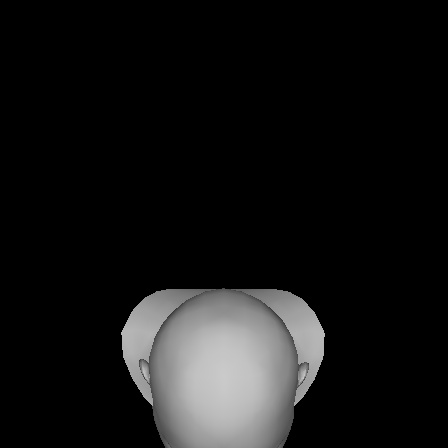</td>
            <td>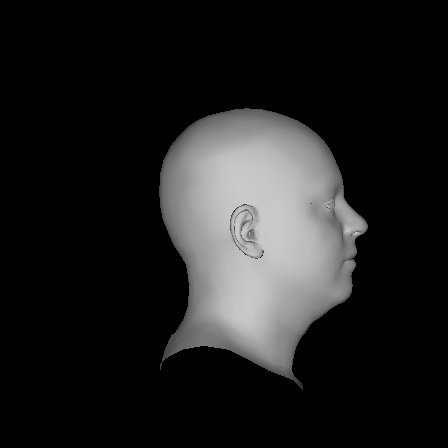</td>
            <td>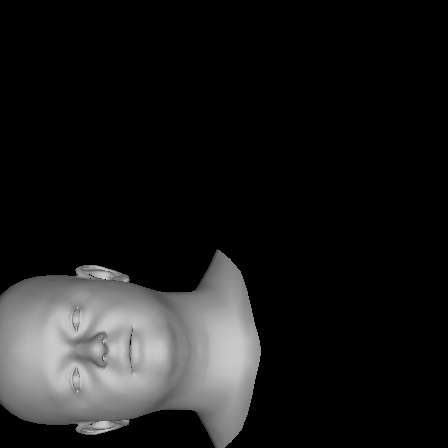</td>
        </tr>
        <tr>
            <th>pose[3] = 30</th>
            <th>pose[4] = 30</th>
            <th>pose[5] = 30</th>
        </tr>
        <tr>
            <td>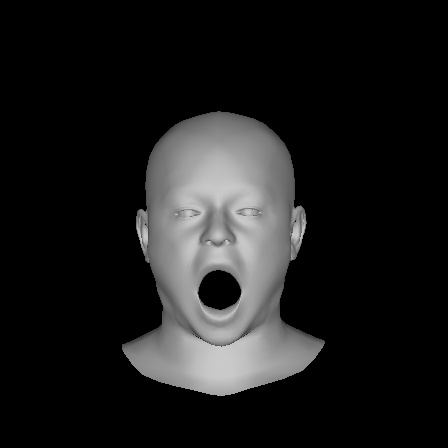</td>
            <td>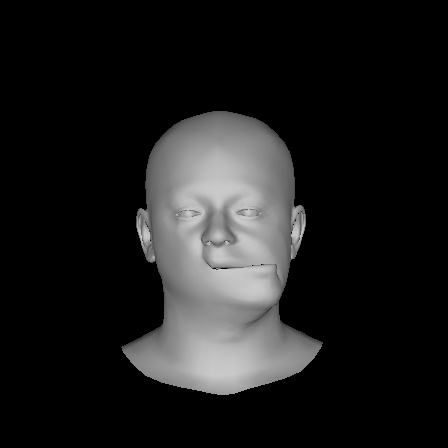</td>
            <td>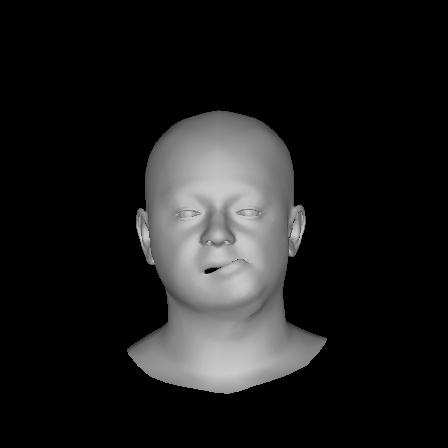</td>
        </tr>
    </table>
</div>

## camera example

<div>
    <table>
        <tr>
            <th>cam[:] = 1., 0., 0.</th>
            <th>cam[:] = 10., 0., 0.</th>
        </tr>
        <tr>
            <td>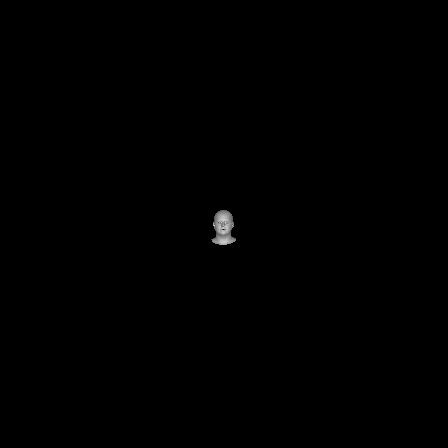</td>
            <td>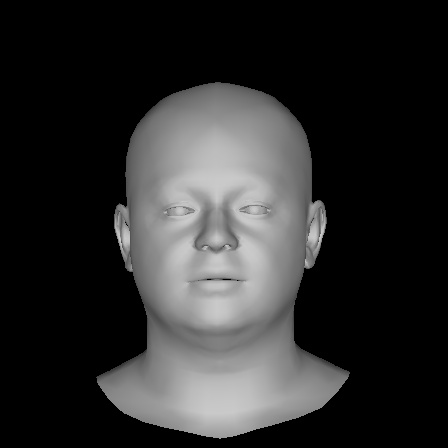</td>
        </tr>
        <tr>
            <th>cam[:] = 8., 0., 0.</th>
            <th>cam[:] = 8., 0.2, 0.</th>
            <th>cam[:] = 8., 0., 0.2</th>
        </tr>
        <tr>
            <td>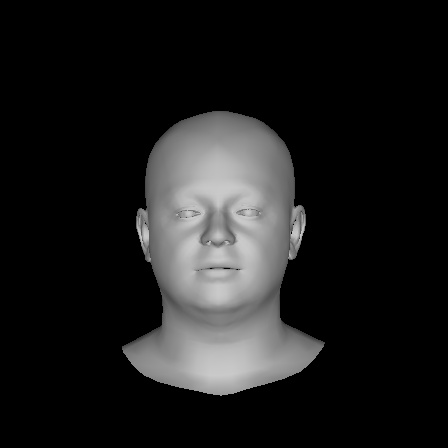</td>
            <td>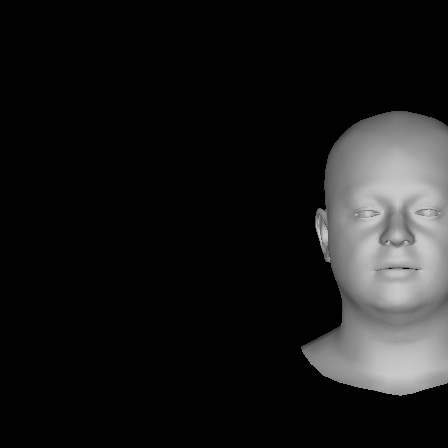</td>
            <td>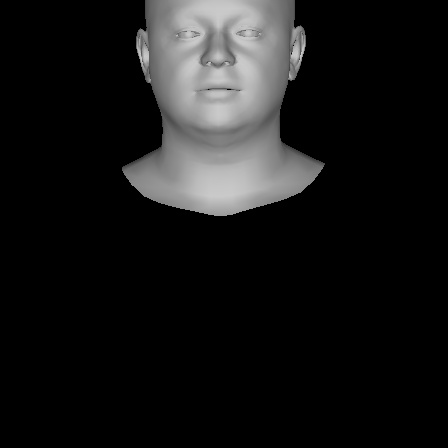</td>
        </tr>
    </table>
</div>

## landmark example
<div>
    <img src="https://user-images.githubusercontent.com/31180090/44790959-39a90100-aba9-11e8-8425-448561070e8a.png" width="400"/>
</div>

In [41]:
import numpy as np
import cv2

end_list = np.array([17, 22, 27, 42, 48, 31, 36, 68], dtype = np.int32) - 1
def plot_kpts(image, kpts, color = 'r'):
    ''' Draw 68 key points
    Args: 
        image: the input image
        kpt: (68, 3).
    '''
    if color == 'r':
        c = (255, 0, 0)
    elif color == 'g':
        c = (0, 255, 0)
    elif color == 'b':
        c = (255, 0, 0)
    image = image.copy()
    kpts = kpts.copy()
    for i in range(kpts.shape[0]):
        st = kpts[i, :2]
        if kpts.shape[1]==4:
            if kpts[i, 3] > 0.5:
                c = (0, 255, 0)
            else:
                c = (0, 0, 255)
        image = cv2.circle(image,(int(st[0]), int(st[1])), 1, c, 2)  
        if i in end_list:
            continue
        ed = kpts[i + 1, :2]
        image = cv2.line(image, (int(st[0]), int(st[1])), (int(ed[0]), int(ed[1])), (255, 255, 255), 1)

    return image

def tensor_vis_landmarks(image, landmarks, gt_landmarks=None, color = 'g', isScale=True):
    # visualize landmarks
    # red color for unvisible ones
    vis_landmarks = []
    image = image.cpu().numpy()
    predicted_landmark = landmarks.detach().cpu().numpy()
    if gt_landmarks is not None:
        gt_landmarks_np = gt_landmarks.detach().cpu().numpy()
    
    image = image.transpose(1,2,0)[:,:,[2,1,0]].copy(); image = (image*255)
    if isScale:
        predicted_landmark[...,0] = predicted_landmark[...,0]*image.shape[1]/2 + image.shape[1]/2
        predicted_landmark[...,1] = predicted_landmark[...,1]*image.shape[0]/2 + image.shape[0]/2
    else:
        predicted_landmark = predicted_landmarks[i]
    if predicted_landmark.shape[0] == 68:
        image_landmarks = plot_kpts(image, predicted_landmark, color)
        if gt_landmarks is not None:
            image_landmarks = plot_verts(image_landmarks, gt_landmarks_np[i]*image.shape[0]/2 + image.shape[0]/2, 'r')
    else:
        image_landmarks = plot_verts(image, predicted_landmark, color)
        if gt_landmarks is not None:
            image_landmarks = plot_verts(image_landmarks, gt_landmarks_np[i]*image.shape[0]/2 + image.shape[0]/2, 'r')
    image_landmarks = torch.from_numpy(image_landmarks[:,:,[2,1,0]].transpose(2,0,1))/255.#, dtype=torch.float32) 
    return image_landmarks

In [42]:
def tensor2image(tensor):
    image = tensor.detach().cpu().numpy()
    image = image*255.
    image = np.maximum(np.minimum(image, 255), 0)
    image = image.transpose(1,2,0)[:,:,[2,1,0]]
    return image.astype(np.uint8).copy()

In [43]:
def transform_points(points, tform, points_scale=None, out_scale=None):
    points_2d = points[:,:2]
        
    #'input points must use original range'
    if points_scale:
        assert points_scale[0]==points_scale[1]
        points_2d = (points_2d*0.5 + 0.5)*points_scale[0]
    # import ipdb; ipdb.set_trace()

    n_points, _ = points.shape
    trans_points_2d = torch.mm(
                    torch.cat([points_2d, torch.ones([n_points, 1], device=points.device, dtype=points.dtype)], dim=-1), 
                    tform
                    ) 
    if out_scale: # h,w of output image size
        trans_points_2d[:,0] = trans_points_2d[:,0]/out_scale[1]*2 - 1
        trans_points_2d[:,1] = trans_points_2d[:,1]/out_scale[0]*2 - 1
    trans_points = torch.cat([trans_points_2d[:,:2], points[:,2:]], dim=-1)
    return trans_points

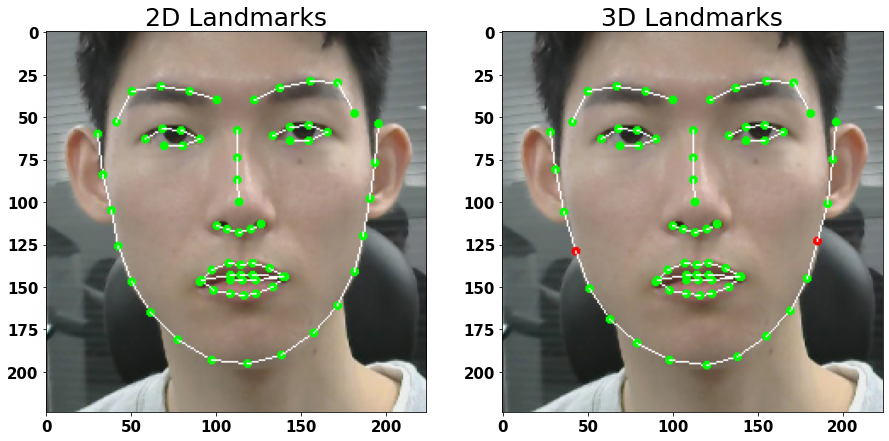

In [44]:
from matplotlib import pyplot as plt

img2d = tensor2image(tensor_vis_landmarks(outputdict['image'], outputdict['landmarks2d'])) # or codedict['images']
img3d = tensor2image(tensor_vis_landmarks(outputdict['image'], outputdict['landmarks3d']))

# cv2.imshow('image',img2d)
# cv2.waitKey(0)
# cv2.imshow('image',img3d)
# cv2.waitKey(0)

img2d = img2d[:,:,::-1]
img3d = img3d[:,:,::-1]

f, axes = plt.subplots(1,2, figsize=(15, 30))

axes[0].set_title('2D Landmarks', fontsize=25)
axes[0].imshow(img2d)
axes[0].tick_params(axis='both', labelsize=15)
axes[1].set_title('3D Landmarks', fontsize=25)
axes[1].imshow(img3d)
axes[1].tick_params(axis='both', labelsize=15)

# cv2.imwrite(wfp, res)

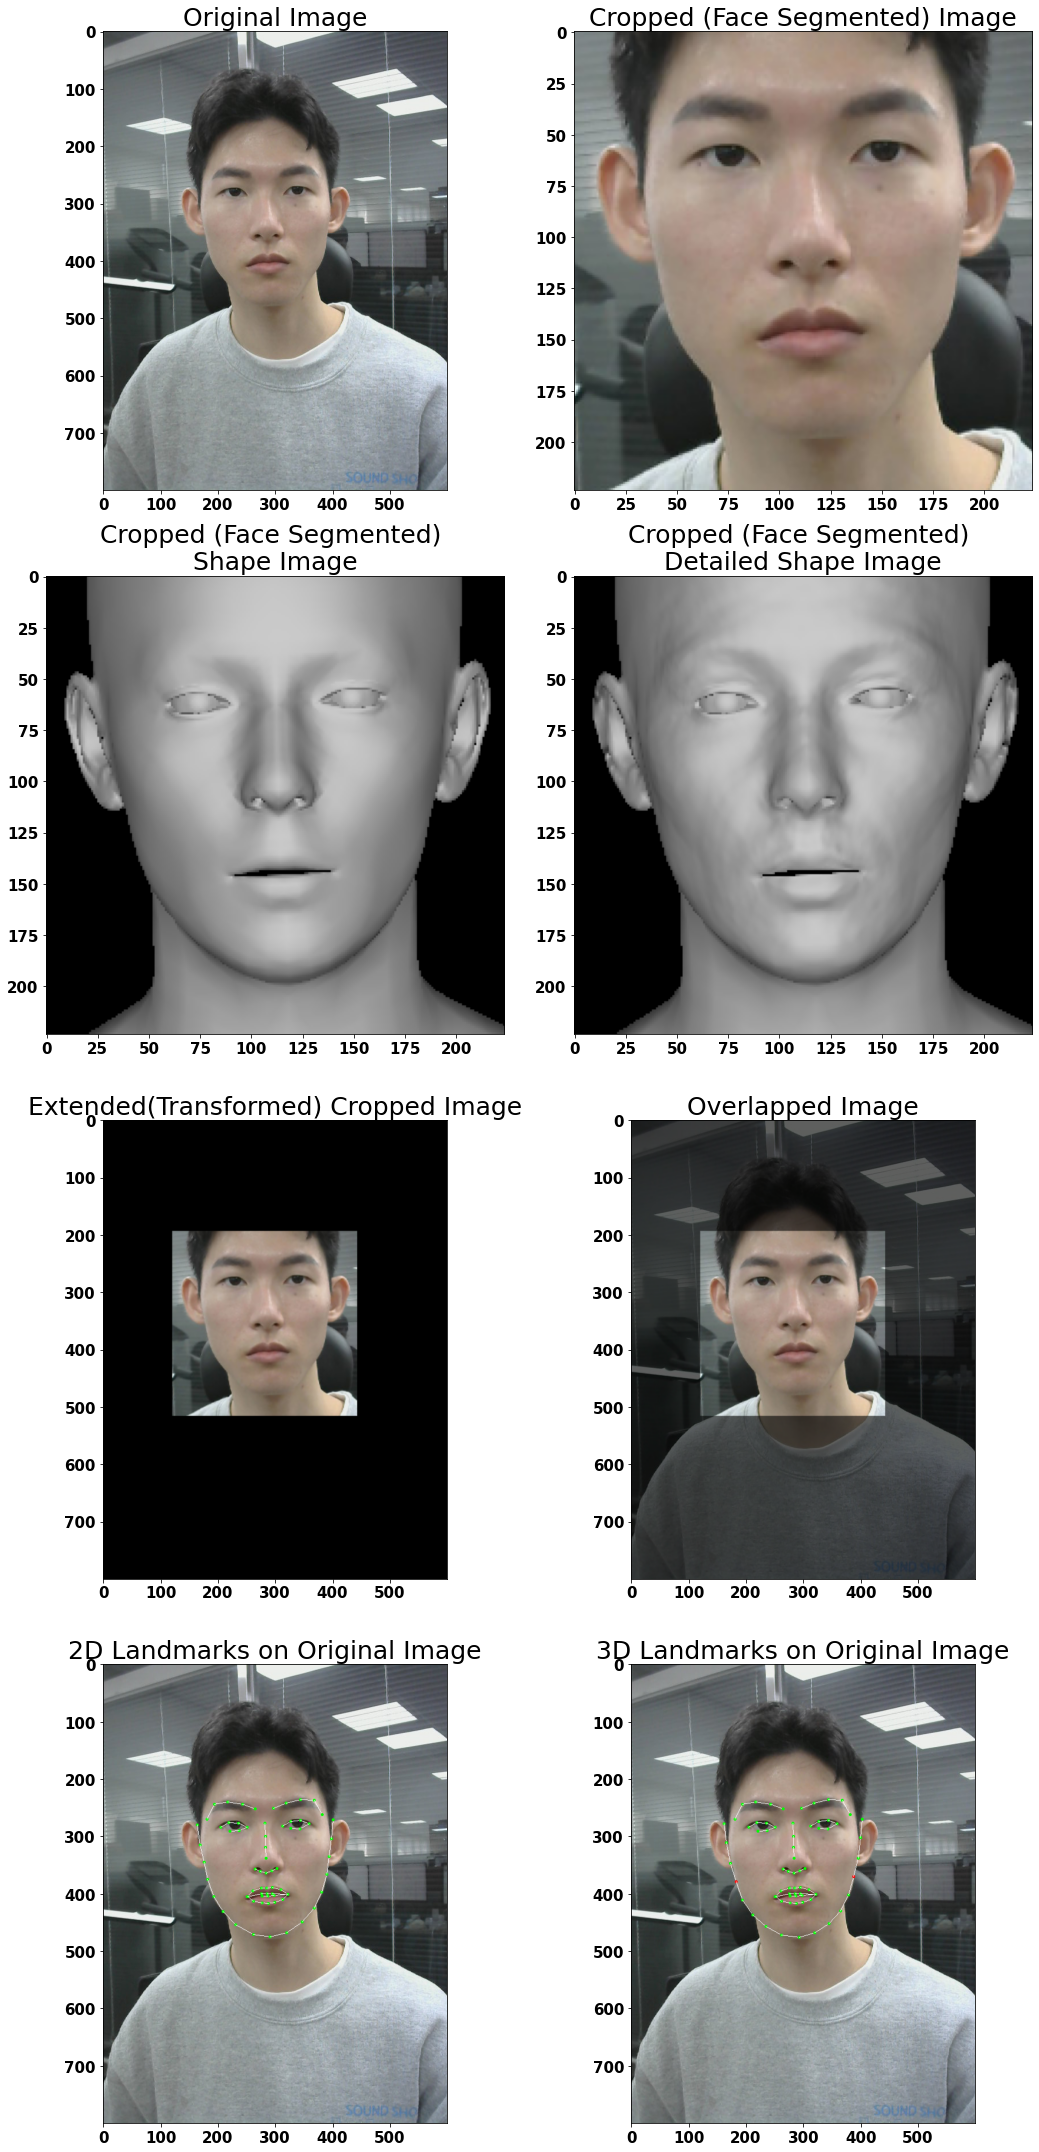

In [68]:
# tform = torch.tensor(dataset[0]['tform'].params)[None, ...]
# tform = torch.inverse(tform).transpose(1,2) #.to(device)

device = 'cuda'

org_img = tensor2image(outputdict['original_image']) # or codedict['images']
crop_img = tensor2image(outputdict['image'])
shape_img = tensor2image(outputdict['shape_image'])
shape_detail_img = tensor2image(outputdict['shape_detail_image'])

tform = outputdict['tform']

points_scale = outputdict['image'].shape[1:]
_, h, w = outputdict['original_image'].shape

# transfrom image
extended_crop_img = skimage.transform.warp(outputdict['image'].detach().cpu().numpy().transpose(1,2,0), 
                    tform, 
                    output_shape=(h, w))
extended_crop_img = (extended_crop_img*255.).astype(np.uint8)

alpha = 0.6
overlay_img = cv2.addWeighted(org_img[:,:,::-1], 1 - alpha, extended_crop_img, alpha, 0)

# transform landmarks
inv_trans_param = torch.tensor(tform.params).float()
inv_trans_param = torch.inverse(inv_trans_param).transpose(0,1).to(device) #inv_trans_param.transpose(1,2).to(device) 
trans_landmarks2d = transform_points(outputdict['landmarks2d'], inv_trans_param, points_scale, [h, w])
trans_landmarks3d = transform_points(outputdict['landmarks3d'], inv_trans_param, points_scale, [h, w])

# plot landmarks
img_ldmk_2d = tensor2image(tensor_vis_landmarks(outputdict['original_image'], trans_landmarks2d))
img_ldmk_3d = tensor2image(tensor_vis_landmarks(outputdict['original_image'], trans_landmarks3d))

# plot images
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
f, axes = plt.subplots(4,2, figsize=(15, 30))

org_img = org_img[:,:,::-1]
crop_img = crop_img[:,:,::-1]
img_ldmk_2d = img_ldmk_2d[:,:,::-1]
img_ldmk_3d = img_ldmk_3d[:,:,::-1]

axes[0,0].set_title('Original Image', fontsize=25)
axes[0,0].imshow(org_img)
axes[0,1].set_title('Cropped (Face Segmented) Image', fontsize=25)
axes[0,1].imshow(crop_img)
axes[1,0].set_title('Cropped (Face Segmented) \nShape Image', fontsize=25)
axes[1,0].imshow(shape_img)
axes[1,1].set_title('Cropped (Face Segmented) \nDetailed Shape Image', fontsize=25)
axes[1,1].imshow(shape_detail_img)
axes[2,0].set_title('Extended(Transformed) Cropped Image', fontsize=25)
axes[2,0].imshow(extended_crop_img)
axes[2,1].set_title('Overlapped Image', fontsize=25)
axes[2,1].imshow(overlay_img)
axes[3,0].set_title('2D Landmarks on Original Image', fontsize=25)
axes[3,0].imshow(img_ldmk_2d)
axes[3,1].set_title('3D Landmarks on Original Image', fontsize=25)
axes[3,1].imshow(img_ldmk_3d)

f.tight_layout()
plt.show()